In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os.path import exists, join
from sklearn.cluster import DBSCAN
from mpl_toolkits.basemap import Basemap
from ipywidgets import interact, IntSlider, SelectionSlider

In [22]:
def load_forecast_track_steps(run_dates, members, ens_name, path):
    track_step_list = []
    for run_date in run_dates:
        print(run_date)
        for member in members:
            filename = join(path, "track_step_{0}_{1}_{2}.csv".format(ens_name, member, run_date.strftime("%Y%m%d")))
            if exists(filename):
                track_step_list.append(pd.read_csv(filename, parse_dates=["Date"]))
                track_step_list[-1]["Run_Date"] = pd.Timestamp(run_date)
                track_step_list[-1]["Member"] = member
            else:
                print(run_date, member, " Missing")
    return pd.concat(track_step_list, ignore_index=True)

def load_obs_track_steps(run_dates, member, path):
    track_step_list = []
    for run_date in run_dates:
        filename = join(path, "track_step_{0}_{1}_{2}.csv".format("obs", member, run_date.strftime("%Y%m%d")))
        if exists(filename):
            track_step_list.append(pd.read_csv(filename, parse_dates=["Date"]))
            track_step_list[-1]["Run_Date"] = pd.Timestamp(run_date)
        else:
            print(run_date, member, " Missing")
    return pd.concat(track_step_list, ignore_index=True)

In [12]:
run_dates = pd.DatetimeIndex(start="2016-05-02", end="2016-06-03", freq="1D")
members = ["wrf-core01_arw"] + ["wrf-core{0:02d}_arw".format(x) for x in range(3, 11)]
csv_path_start = "/hail/djgagne/"
all_tracks = dict()
all_tracks["hailcast"] = load_forecast_track_steps(run_dates, 
                                                   members, 
                                                   "SSEF", 
                                                   join(csv_path_start, "track_data_caps_2016_hailcast_csv/"))
all_tracks["thompson"] = load_forecast_track_steps(run_dates, 
                                                   members, 
                                                   "SSEF", 
                                                   join(csv_path_start, "track_data_caps_2016_thompson_csv/"))

2016-05-02 00:00:00
2016-05-03 00:00:00
2016-05-04 00:00:00
2016-05-05 00:00:00
2016-05-06 00:00:00
2016-05-07 00:00:00
(Timestamp('2016-05-07 00:00:00', freq='D'), 'wrf-core01_arw', ' Missing')
(Timestamp('2016-05-07 00:00:00', freq='D'), 'wrf-core03_arw', ' Missing')
(Timestamp('2016-05-07 00:00:00', freq='D'), 'wrf-core04_arw', ' Missing')
(Timestamp('2016-05-07 00:00:00', freq='D'), 'wrf-core05_arw', ' Missing')
(Timestamp('2016-05-07 00:00:00', freq='D'), 'wrf-core06_arw', ' Missing')
(Timestamp('2016-05-07 00:00:00', freq='D'), 'wrf-core07_arw', ' Missing')
(Timestamp('2016-05-07 00:00:00', freq='D'), 'wrf-core08_arw', ' Missing')
(Timestamp('2016-05-07 00:00:00', freq='D'), 'wrf-core09_arw', ' Missing')
(Timestamp('2016-05-07 00:00:00', freq='D'), 'wrf-core10_arw', ' Missing')
2016-05-08 00:00:00
(Timestamp('2016-05-08 00:00:00', freq='D'), 'wrf-core01_arw', ' Missing')
(Timestamp('2016-05-08 00:00:00', freq='D'), 'wrf-core03_arw', ' Missing')
(Timestamp('2016-05-08 00:00:00', f

(Timestamp('2016-05-09 00:00:00', freq='D'), 'wrf-core10_arw', ' Missing')
2016-05-10 00:00:00
2016-05-11 00:00:00
(Timestamp('2016-05-11 00:00:00', freq='D'), 'wrf-core03_arw', ' Missing')
(Timestamp('2016-05-11 00:00:00', freq='D'), 'wrf-core06_arw', ' Missing')
2016-05-12 00:00:00
(Timestamp('2016-05-12 00:00:00', freq='D'), 'wrf-core03_arw', ' Missing')
(Timestamp('2016-05-12 00:00:00', freq='D'), 'wrf-core06_arw', ' Missing')
2016-05-13 00:00:00
2016-05-14 00:00:00
(Timestamp('2016-05-14 00:00:00', freq='D'), 'wrf-core01_arw', ' Missing')
(Timestamp('2016-05-14 00:00:00', freq='D'), 'wrf-core03_arw', ' Missing')
(Timestamp('2016-05-14 00:00:00', freq='D'), 'wrf-core04_arw', ' Missing')
(Timestamp('2016-05-14 00:00:00', freq='D'), 'wrf-core05_arw', ' Missing')
(Timestamp('2016-05-14 00:00:00', freq='D'), 'wrf-core06_arw', ' Missing')
(Timestamp('2016-05-14 00:00:00', freq='D'), 'wrf-core07_arw', ' Missing')
(Timestamp('2016-05-14 00:00:00', freq='D'), 'wrf-core08_arw', ' Missing')


In [24]:
obs_tracks = load_obs_track_steps(run_dates, 
                                  "wrf-core01_arw", 
                                  join(csv_path_start, "track_data_caps_2016_hailcast_csv/"))

(Timestamp('2016-05-07 00:00:00', freq='D'), 'wrf-core01_arw', ' Missing')
(Timestamp('2016-05-08 00:00:00', freq='D'), 'wrf-core01_arw', ' Missing')
(Timestamp('2016-05-14 00:00:00', freq='D'), 'wrf-core01_arw', ' Missing')
(Timestamp('2016-05-15 00:00:00', freq='D'), 'wrf-core01_arw', ' Missing')
(Timestamp('2016-05-21 00:00:00', freq='D'), 'wrf-core01_arw', ' Missing')
(Timestamp('2016-05-22 00:00:00', freq='D'), 'wrf-core01_arw', ' Missing')
(Timestamp('2016-05-28 00:00:00', freq='D'), 'wrf-core01_arw', ' Missing')
(Timestamp('2016-05-29 00:00:00', freq='D'), 'wrf-core01_arw', ' Missing')


In [6]:
bmap = Basemap(projection="cyl", resolution="l", llcrnrlon=-125, llcrnrlat=25, urcrnrlon=-60, urcrnrlat=50, fix_aspect=False)


In [34]:
%matplotlib inline
def draw_hail_points(date, member):
    fig, axes = plt.subplots(3, 1, figsize=(8, 12))
    plt.subplots_adjust(0.02, 0.02, 0.98, 0.95, hspace=0.05)
    for ax in axes:
        bmap.drawstates(ax=ax)
        bmap.drawcoastlines(ax=ax)
        bmap.drawcountries(ax=ax)
    hc_idxs = np.where((all_tracks["hailcast"]["Run_Date"] == date) & 
                       (all_tracks["hailcast"]["Member"] == member))[0]
    th_idxs = np.where((all_tracks["thompson"]["Run_Date"] == date) & 
                       (all_tracks["thompson"]["Member"] == member))[0]
    ob_idxs = np.where(obs_tracks["Run_Date"] == date)[0]
    hc_size_order = np.argsort(all_tracks["hailcast"].loc[hc_idxs, "hailsz_max"])
    th_size_order = np.argsort(all_tracks["thompson"].loc[th_idxs, "hailk1_max"])
    ob_size_order = np.argsort(obs_tracks.loc[ob_idxs, "MESH_max"])
    axes[0].scatter(all_tracks["hailcast"].loc[hc_idxs[hc_size_order], "Centroid_Lon"], 
                all_tracks["hailcast"].loc[hc_idxs[hc_size_order], "Centroid_Lat"], 10, 
                all_tracks["hailcast"].loc[hc_idxs[hc_size_order], "hailsz_max"],
               vmin=0, vmax=100)
    axes[0].set(ylabel="HAILCAST")
    axes[1].scatter(all_tracks["thompson"].loc[th_idxs[th_size_order], "Centroid_Lon"], 
                    all_tracks["thompson"].loc[th_idxs[th_size_order], "Centroid_Lat"], 10, 
                    all_tracks["thompson"].loc[th_idxs[th_size_order], "hailk1_max"],
                     vmin=0, vmax=100)
    axes[1].set(ylabel="Thompson")
    axes[2].scatter(obs_tracks.loc[ob_idxs[ob_size_order], "Centroid_Lon"], 
                    obs_tracks.loc[ob_idxs[ob_size_order], "Centroid_Lat"], 10, 
                    obs_tracks.loc[ob_idxs[ob_size_order], "MESH_max"],
                     vmin=0, vmax=100)
    axes[2].set(ylabel="MESH")
    axes[0].set_title(date)
    plt.show()
interact(draw_hail_points, 
         date=SelectionSlider(options=pd.DatetimeIndex(all_tracks["hailcast"]["Run_Date"]).unique().tolist()),
         member=SelectionSlider(options=members))

<function __main__.draw_hail_points>

In [13]:
all_tracks["hailcast"]["Run_Date"]

0       2016-05-02
1       2016-05-02
2       2016-05-02
3       2016-05-02
4       2016-05-02
5       2016-05-02
6       2016-05-02
7       2016-05-02
8       2016-05-02
9       2016-05-02
10      2016-05-02
11      2016-05-02
12      2016-05-02
13      2016-05-02
14      2016-05-02
15      2016-05-02
16      2016-05-02
17      2016-05-02
18      2016-05-02
19      2016-05-02
20      2016-05-02
21      2016-05-02
22      2016-05-02
23      2016-05-02
24      2016-05-02
25      2016-05-02
26      2016-05-02
27      2016-05-02
28      2016-05-02
29      2016-05-02
           ...    
77677   2016-06-03
77678   2016-06-03
77679   2016-06-03
77680   2016-06-03
77681   2016-06-03
77682   2016-06-03
77683   2016-06-03
77684   2016-06-03
77685   2016-06-03
77686   2016-06-03
77687   2016-06-03
77688   2016-06-03
77689   2016-06-03
77690   2016-06-03
77691   2016-06-03
77692   2016-06-03
77693   2016-06-03
77694   2016-06-03
77695   2016-06-03
77696   2016-06-03
77697   2016-06-03
77698   2016

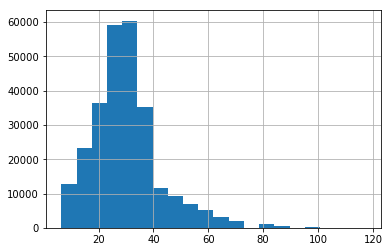

In [21]:
all_tracks["thompson"]["hailk1_max"].hist(bins=20)

In [25]:
obs_tracks.columns

Index([u'Step_ID', u'Obs_Track_ID', u'Date', u'Forecast_Hour',
       u'Valid_Hour_UTC', u'Duration', u'Centroid_Lon', u'Centroid_Lat',
       u'MESH_mean', u'MESH_max', u'MESH_min', u'MESH_std',
       u'MESH_percentile_10', u'MESH_percentile_25', u'MESH_percentile_50',
       u'MESH_percentile_75', u'MESH_percentile_90', u'Run_Date'],
      dtype='object')

In [49]:
%matplotlib inline
def draw_hail_clusters(date, member):
    fig, axes = plt.subplots(3, 1, figsize=(8, 12))
    plt.subplots_adjust(0.02, 0.02, 0.98, 0.95, hspace=0.05)
    for ax in axes:
        bmap.drawstates(ax=ax)
        bmap.drawcoastlines(ax=ax)
        bmap.drawcountries(ax=ax)
    hc_idxs = np.where((all_tracks["hailcast"]["Run_Date"] == date) & 
                       (all_tracks["hailcast"]["Member"] == member))[0]
    th_idxs = np.where((all_tracks["thompson"]["Run_Date"] == date) & 
                       (all_tracks["thompson"]["Member"] == member))[0]
    ob_idxs = np.where(obs_tracks["Run_Date"] == date)[0]
    hc_size_order = np.argsort(all_tracks["hailcast"].loc[hc_idxs, "hailsz_max"])
    th_size_order = np.argsort(all_tracks["thompson"].loc[th_idxs, "hailk1_max"])
    ob_size_order = np.argsort(obs_tracks.loc[ob_idxs, "MESH_max"])
    db_hc = DBSCAN(eps=1, min_samples=5)
    db_th = DBSCAN(eps=1, min_samples=5)
    db_me = DBSCAN(eps=1, min_samples=5)
    if len(hc_idxs) > 0:
        hc_clusters = db_hc.fit_predict(all_tracks["hailcast"].loc[hc_idxs, ["Centroid_Lon", "Centroid_Lat"]])
    else:
        hc_clusters = np.array([])
    if len(th_idxs) > 0:
        th_clusters = db_hc.fit_predict(all_tracks["thompson"].loc[th_idxs, ["Centroid_Lon", "Centroid_Lat"]])
    else:
        th_clusters = np.array([])
    if len(ob_idxs) > 0:
        me_clusters = db_hc.fit_predict(obs_tracks.loc[ob_idxs, ["Centroid_Lon", "Centroid_Lat"]])
    else:
        me_clusters = np.array([])
    axes[0].scatter(all_tracks["hailcast"].loc[hc_idxs[hc_size_order], "Centroid_Lon"], 
                all_tracks["hailcast"].loc[hc_idxs[hc_size_order], "Centroid_Lat"], 10, 
                hc_clusters[hc_size_order],
               vmin=0, vmax=10)
    axes[0].set(ylabel="HAILCAST")
    axes[1].scatter(all_tracks["thompson"].loc[th_idxs[th_size_order], "Centroid_Lon"], 
                    all_tracks["thompson"].loc[th_idxs[th_size_order], "Centroid_Lat"], 10, 
                    th_clusters[th_size_order],
                     vmin=0, vmax=10)
    axes[1].set(ylabel="Thompson")
    axes[2].scatter(obs_tracks.loc[ob_idxs[ob_size_order], "Centroid_Lon"], 
                    obs_tracks.loc[ob_idxs[ob_size_order], "Centroid_Lat"], 10, 
                    me_clusters[ob_size_order],
                     vmin=0, vmax=10)
    axes[2].set(ylabel="MESH")
    axes[0].set_title(date)
    plt.show()
interact(draw_hail_clusters, 
         date=SelectionSlider(options=pd.DatetimeIndex(all_tracks["hailcast"]["Run_Date"]).unique().tolist()),
         member=SelectionSlider(options=members))

<function __main__.draw_hail_clusters>